In [1]:
import pefile
import os
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import subprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re


In [2]:
# constantes
malware_path = "MALWR_lab4/MALWR/"
unpacked_path = "MALWR_lab4/UNPACKED/"
MAX_CLUSTERS = 10
os.makedirs(unpacked_path, exist_ok=True)

In [3]:
def get_md5(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def extract_imported_functions(pe):
    functions = set()
    if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            for imp in entry.imports:
                if imp.name:
                    functions.add(imp.name.decode(errors='ignore'))
    return " ".join(functions)

def calculate_entropy(data):
    if not data:
        return 0
    freq = {b: data.count(b) for b in set(data)}
    data_len = len(data)
    entropy = -sum((f / data_len) * math.log2(f / data_len) for f in freq.values())
    return entropy

def check_packed(pe):
    high_entropy_sections = sum(1 for section in pe.sections if calculate_entropy(section.get_data()) > 7.5)
    import_count = sum(len(entry.imports) for entry in getattr(pe, 'DIRECTORY_ENTRY_IMPORT', []))
    return high_entropy_sections > 0 or import_count == 0

def try_unpack(file_path):
    unpacked_file_path = os.path.join(unpacked_path, os.path.basename(file_path))
    
    try:
        result = subprocess.run(["upx", "-d", file_path, "-o", unpacked_file_path],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if "Unpacked" in result.stdout or "Unpacked" in result.stderr:
            return unpacked_file_path  # Devuelve la nueva ruta desempaquetada
    except Exception as e:
        print(f"Error desempaquetando {os.path.basename(file_path)}: {e}")

    return None  # Si falla, devuelve None

def extract_strings(file_path, min_length=4):
    with open(file_path, "rb") as f:
        data = f.read()
    strings = re.findall(rb"[ -~]{%d,}" % min_length, data)  # Filtrar solo caracteres imprimibles
    return " ".join(s.decode(errors="ignore") for s in strings)


In [4]:

dataset = []
for root, _, files in os.walk(malware_path):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            pe = pefile.PE(file_path)
            is_packed = check_packed(pe)

            if is_packed:
                unpacked_file_path = try_unpack(file_path)
                if unpacked_file_path:
                    file_path = unpacked_file_path  
                    pe = pefile.PE(file_path)  
                else:
                    continue  

            file_hash = get_md5(file_path)
            imported_functions = extract_imported_functions(pe)
            extracted_strings = extract_strings(file_path)

            dataset.append({
                "Hash": file_hash,
                "Functions": imported_functions, # col functions para poder realizar el grafo
                "String": extracted_strings  # Col string para poder realizar el grafo
            })
            print(f"Procesado: {file}")

        except pefile.PEFormatError:
            print(f"{file} no es un archivo PE válido")
        except Exception as e:
            print(f"Error con {file}: {e}")


Procesado: 650A6FCA433EE243391E4B4C11F09438
Procesado: F8437E44748D2C3FCF84019766F4E6DC
Procesado: DS22_A670D13D4D014169C4080328B8FEB86
Procesado: NBV_8B75BCBFF174C25A0161F30758509A44
Procesado: FTTR9EA3C16194CE354C244C1B74C46CD92E
Procesado: NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4
Procesado: B98hX8E8622C393D7E832D39E620EAD5D3B49
Procesado: HJGQDD892986B2249B5214639ECC8AC0223
Procesado: B07322743778B5868475DBE66EEDAC4F
Procesado: EEE99EC8AA67B05407C01094184C33D2B5A44
Procesado: TG78Z__727A6800991EEAD454E53E8AF164A99C
Procesado: POL55_A4F1ECC4D25B33395196B5D51A06790
Procesado: VBMM9_149B7BD7218AAB4E257D28469FDDB0D
Procesado: PL98_BD8B082B7711BC980252F988BB0CA936
Procesado: FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2
Procesado: GBV66_8F259BB36E00D124963CFA9B86F502E
Procesado: 8442AE37B91F279A9F06DE4C60B286A3
Procesado: 33DE5067A433A6EC5C328067DC18EC37
Procesado: SAM_B659D71AE168E774FAAF38DB30F4A84
Procesado: K99_C3A9A7B026BFE0E55FF219FD6AA7D94
Procesado: AAAz2E1B6940985A23E5639450F8391820655
P

In [5]:
df = pd.DataFrame(dataset)

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


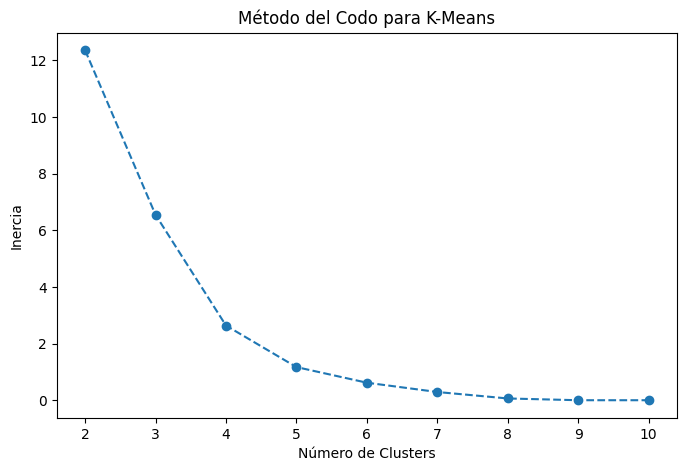

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


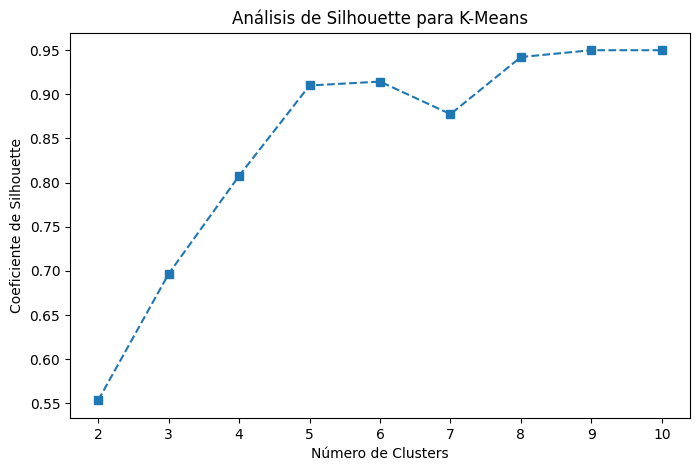

In [6]:

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Functions"])

inertia = []
for k in range(2, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, MAX_CLUSTERS+1), inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.show()

silhouette_scores = []
for k in range(2, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, MAX_CLUSTERS+1), silhouette_scores, marker='s', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Análisis de Silhouette para K-Means')
plt.show()


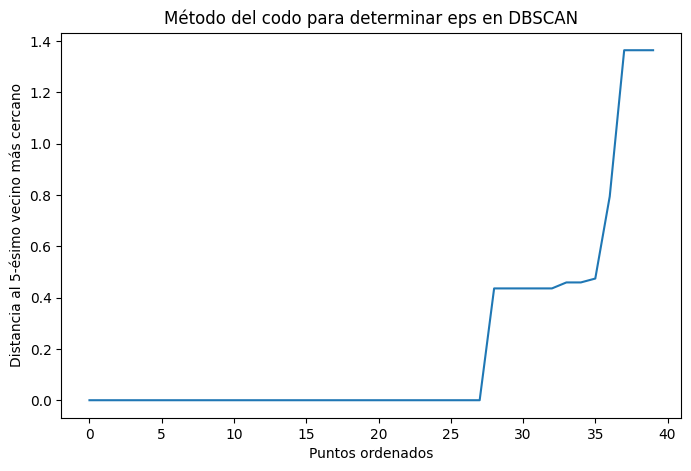

Número de clusters detectados: 0
                               Hash  \
0  3088654f3dd7e874d54f198225615f35   
1  1afc5d3ff651366800117c79f438ca58   
2  87d42bf400e7e4bbc9a634c99b0c3885   
3  cefcce265f853877c15e98e9a562e4c4   
4  3318200eef60f909faafbb97587248c5   
5  8874b81f600b0a93723be682e939d7f2   
6  c738884c1337cf572e114725a112f76f   
7  6c82816e9a59fef04f8bf0d469a21090   
8  cf1a8c92b688b47490580da6ba39f041   
9  f95fc5593473652bbbc419331a3ffc06   

                                           Functions  DBSCAN_Cluster_New  
0  WriteFile SHChangeNotify htons Sleep GetStartu...                  -1  
1  WriteFile SHChangeNotify htons Sleep GetStartu...                  -1  
2  wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...                  -1  
3  WriteFile SHChangeNotify htons Sleep GetStartu...                  -1  
4  WriteFile htons Sleep GetStartupInfoA __getmai...                  -1  
5  wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...                  -1  
6  WriteFile

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


# Vectorización de la columna 'Functions'
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Functions"].astype(str))

# Método del codo para determinar eps
k = 5  # Número de vecinos más cercanos
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)

# Ordenar las distancias y graficarlas para visualizar el codo
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino más cercano")
plt.title("Método del codo para determinar eps en DBSCAN")
plt.show()

# Selección automática de eps basada en el percentil 85 (ajustable según la gráfica)
eps_optimo = np.percentile(distances, 85)  

# Selección dinámica de min_samples
min_samples_optimo = X.shape[1] * 2  # Doble del número de características

# Aplicamos DBSCAN con estos parámetros
dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples_optimo)
labels_dbscan = dbscan.fit_predict(X)

# Guardamos los resultados en el DataFrame
df["DBSCAN_Cluster_New"] = labels_dbscan

# Contamos el número de clusters detectados (excluyendo el ruido -1)
num_clusters_detectados = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Número de clusters detectados: {num_clusters_detectados}")

# Mostrar algunas filas con los nuevos clusters asignados
print(df[["Hash", "Functions", "DBSCAN_Cluster_New"]].head(10))


In [8]:
# Basado en el análisis del codo, se elige 4 como el número de clusters óptimos, se puede probar con 5, en caso de considerarse
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(X)
df["Family"] = df["KMeans_Cluster"].apply(lambda x: f"Fam{x}")

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
df["DBSCAN_Cluster"] = dbscan.fit_predict(X)

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X.toarray())


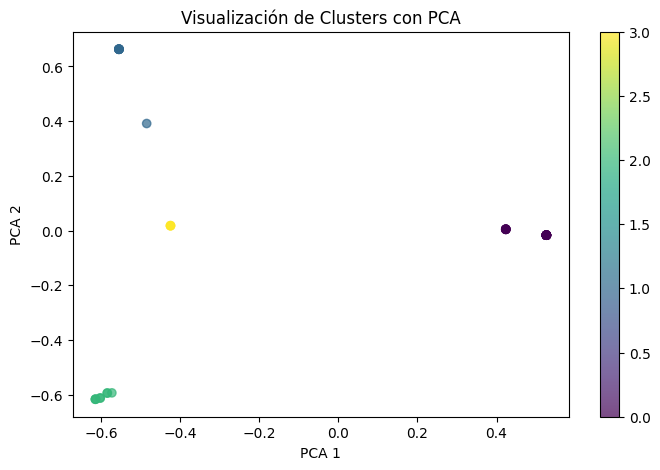

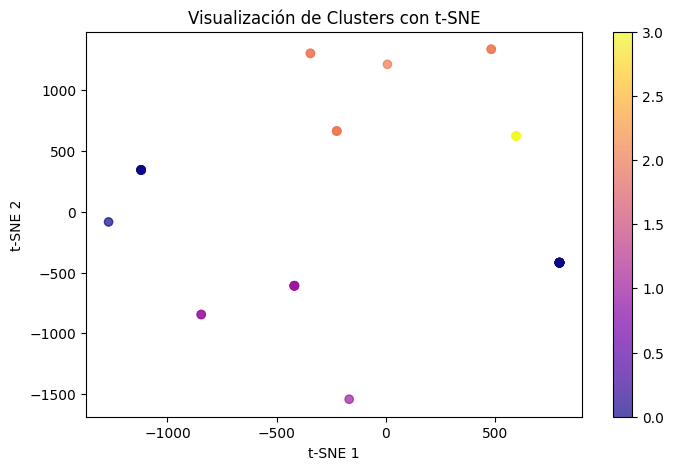

Dataset guardado exitosamente como malware_dataset.csv


In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["KMeans_Cluster"], cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar()
plt.show()


tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_X = tsne.fit_transform(X.toarray())
plt.figure(figsize=(8, 5))
plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=df["KMeans_Cluster"], cmap='plasma', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Visualización de Clusters con t-SNE')
plt.colorbar()
plt.show()

df.to_csv("malware_dataset.csv", index=False)
print("Dataset guardado exitosamente como malware_dataset.csv")


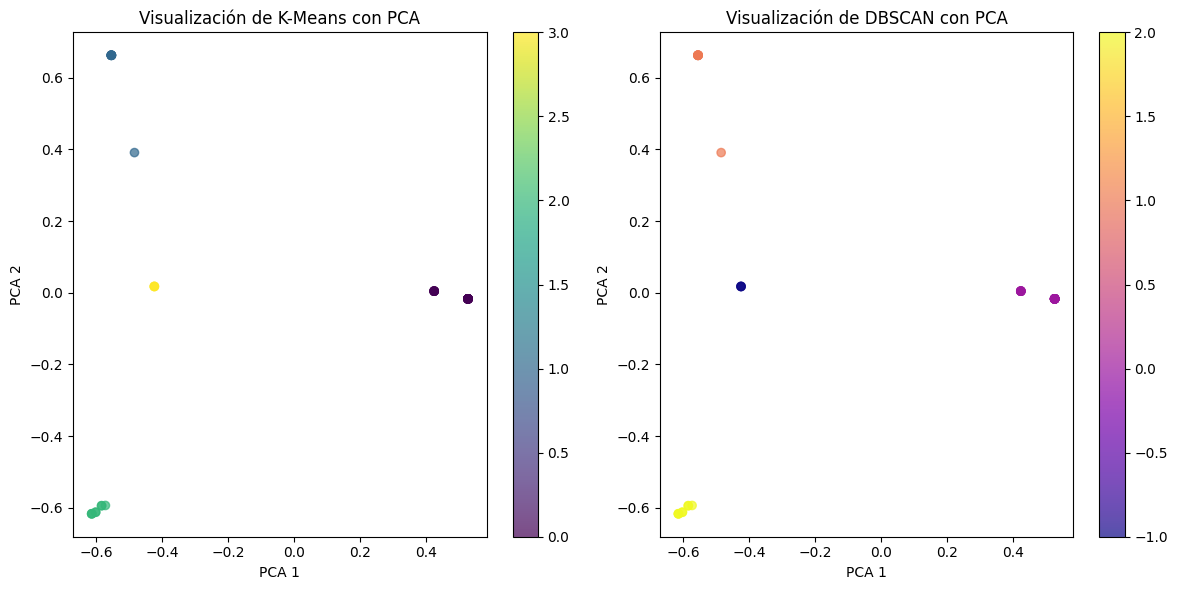

In [10]:
# Visualización de los embeddings con PCA para KMeans vs DBSCAN
plt.figure(figsize=(12, 6))

# Subgráfico 1: PCA - KMeans
plt.subplot(1, 2, 1)
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["KMeans_Cluster"], cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de K-Means con PCA')
plt.colorbar()

# Subgráfico 2: PCA - DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["DBSCAN_Cluster"], cmap='plasma', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de DBSCAN con PCA')
plt.colorbar()

plt.tight_layout()
plt.show()


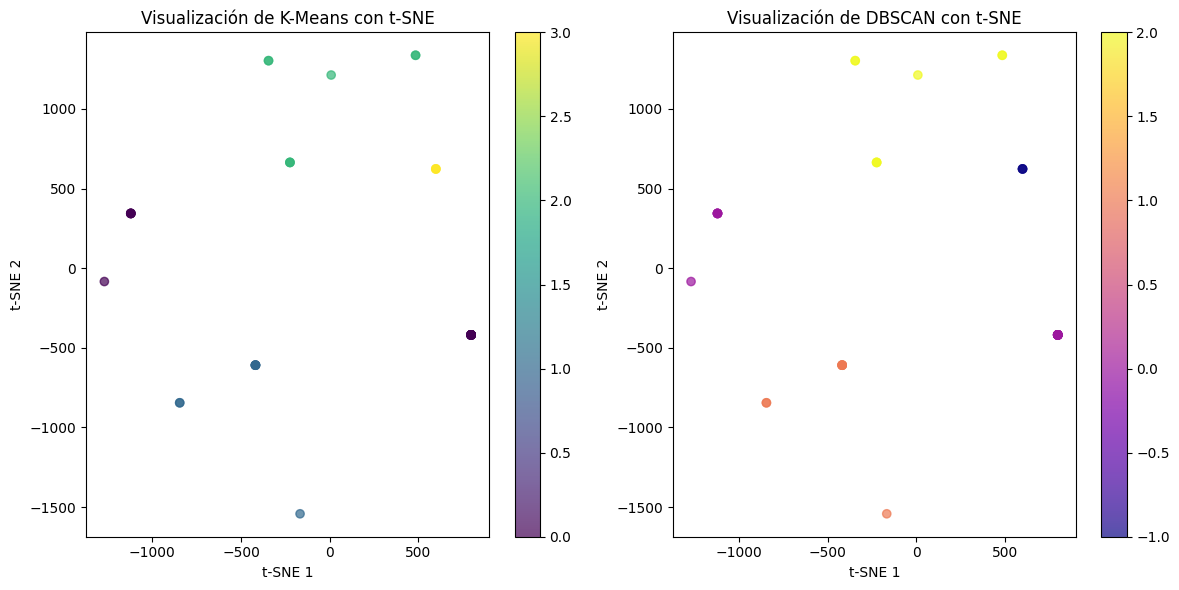

In [11]:
# Visualización de los embeddings con t-SNE para KMeans vs DBSCAN
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_X = tsne.fit_transform(X.toarray())  # Convertimos X a denso usando .toarray()

plt.figure(figsize=(12, 6))

# Subgráfico 1: t-SNE - KMeans
plt.subplot(1, 2, 1)
plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=df["KMeans_Cluster"], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Visualización de K-Means con t-SNE')
plt.colorbar()

# Subgráfico 2: t-SNE - DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=df["DBSCAN_Cluster"], cmap='plasma', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Visualización de DBSCAN con t-SNE')
plt.colorbar()

plt.tight_layout()
plt.show()


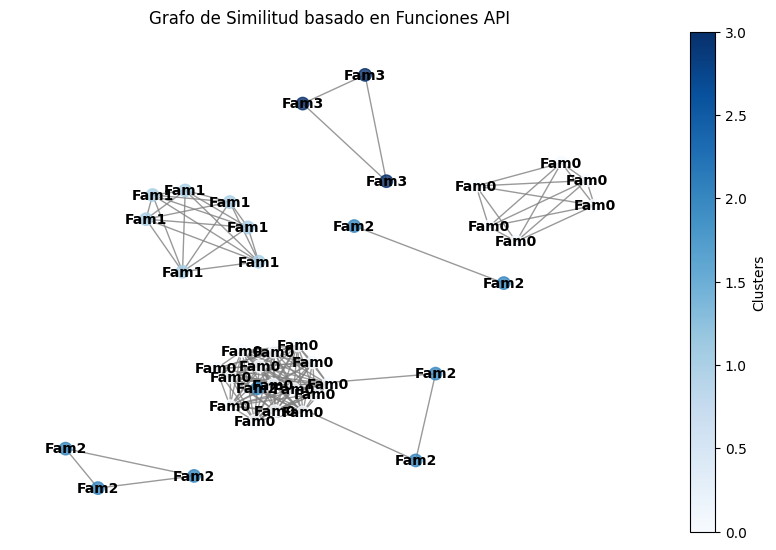

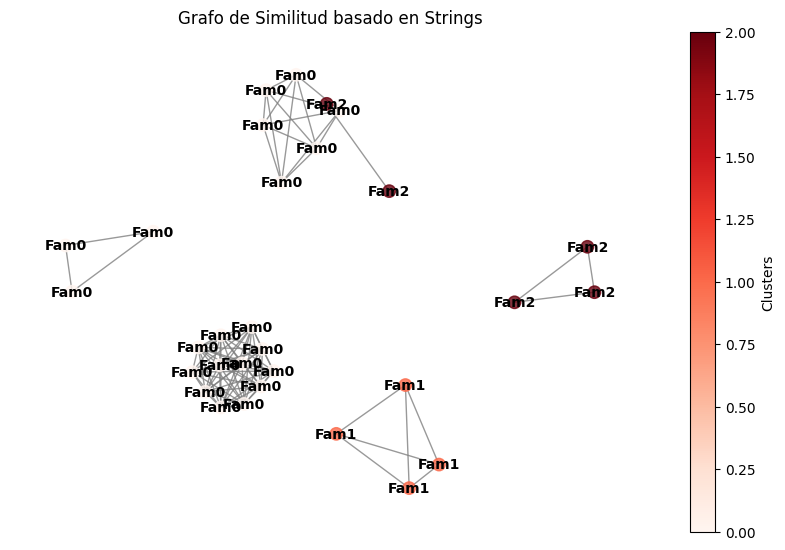

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Función para calcular la similitud de Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calcular la similitud de Jaccard entre las funciones (ajustar según tu formato)
functions_jaccard = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        set1 = set(df.loc[i, "Functions"].split())  # Dividiendo las funciones por espacio
        set2 = set(df.loc[j, "Functions"].split())
        similarity = jaccard_similarity(set1, set2)
        functions_jaccard[i, j] = similarity
        functions_jaccard[j, i] = similarity  # Simetría

# Calcular la similitud de Jaccard entre las cadenas de texto
strings_jaccard = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        set1 = set(df.loc[i, "String"].split())  # Dividiendo las cadenas de texto
        set2 = set(df.loc[j, "String"].split())
        similarity = jaccard_similarity(set1, set2)
        strings_jaccard[i, j] = similarity
        strings_jaccard[j, i] = similarity  # Simetría

# Grafo de similitud basado en API
G_functions = nx.Graph()
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if functions_jaccard[i, j] > 0.9:  # Umbral de similitud
            G_functions.add_edge(df.loc[i, "Hash"], df.loc[j, "Hash"], weight=functions_jaccard[i, j])

# Grafo de similitud basado en Strings
G_strings = nx.Graph()
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if strings_jaccard[i, j] > 0.9:  # Umbral de similitud
            G_strings.add_edge(df.loc[i, "Hash"], df.loc[j, "Hash"], weight=strings_jaccard[i, j])

# Función de dibujo del grafo con diferenciación de funciones API y strings
def draw_graph(graph, title, df, clusters, filename, graph_type):
    plt.figure(figsize=(8, 5))
    
    # Asignar posiciones con layout de fuerza
    pos = nx.spring_layout(graph, seed=42, k=0.3, iterations=20)
    
    # Obtener colores según cluster (para todos los grafos)
    node_colors = [clusters[df[df["Hash"] == node].index[0]] for node in graph.nodes]
    
    # Diferenciar colores de nodos según tipo de grafo
    if graph_type == "functions":
        node_color_map = plt.cm.Blues  # Usar color azul para funciones API
    else:
        node_color_map = plt.cm.Reds  # Usar color rojo para strings
    
    # Dibujar el grafo
    nx.draw(graph, pos, with_labels=False, node_size=80, node_color=node_colors, cmap=node_color_map, alpha=0.8, edge_color='gray')
    
    # Etiquetas de los nodos con las familias
    labels = {node: f"Fam{clusters[df[df['Hash'] == node].index[0]]}" for node in graph.nodes}
    nx.draw_networkx_labels(graph, pos, labels, font_size=10, font_color="black", font_weight="bold", verticalalignment="center")
    
    # Colorbar
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = cm.ScalarMappable(cmap=node_color_map, norm=norm)
    sm.set_array([])  
    plt.colorbar(sm, ax=plt.gca(), label="Clusters")
    
    # Título y leyenda
    plt.title(title)
    
    # Guardar el gráfico como archivo .png
    plt.savefig(filename, format='PNG', bbox_inches='tight')
    plt.close()  # Cerrar la figura
    
    # Mostrar el gráfico
    plt.figure(figsize=(8, 5))
    nx.draw(graph, pos, with_labels=False, node_size=80, node_color=node_colors, cmap=node_color_map, alpha=0.8, edge_color='gray')
    nx.draw_networkx_labels(graph, pos, labels, font_size=10, font_color="black", font_weight="bold", verticalalignment="center")
    plt.colorbar(sm, ax=plt.gca(), label="Clusters")
    plt.title(title)
    plt.show()

# Dibujar los grafos con diferencias visuales
draw_graph(G_functions, "Grafo de Similitud basado en Funciones API", df, df["KMeans_Cluster"], "grafo_similitud_funciones_api.png", "functions")
draw_graph(G_strings, "Grafo de Similitud basado en Strings", df, df["KMeans_Cluster"], "grafo_similitud_strings.png", "strings")


In [13]:
import os
import pefile
import pandas as pd

In [14]:
df2 = pd.read_csv("malware_dataset.csv")

In [15]:
df2

,Hash,Functions,String,DBSCAN_Cluster_New,KMeans_Cluster,Family,DBSCAN_Cluster
0,3088654f3dd7e874d54f198225615f35,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0
1,1afc5d3ff651366800117c79f438ca58,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0
2,87d42bf400e7e4bbc9a634c99b0c3885,wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...,!This program cannot be run in DOS mode. 5bRic...,-1,1,Fam1,1
3,cefcce265f853877c15e98e9a562e4c4,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0
4,3318200eef60f909faafbb97587248c5,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0
5,8874b81f600b0a93723be682e939d7f2,wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...,!This program cannot be run in DOS mode. 5bRic...,-1,1,Fam1,1
6,c738884c1337cf572e114725a112f76f,WriteFile OpenDesktopA Sleep OpenProcess _ftol...,!This program cannot be run in DOS mode. Rich ...,-1,2,Fam2,2
7,6c82816e9a59fef04f8bf0d469a21090,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0
8,cf1a8c92b688b47490580da6ba39f041,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0
9,f95fc5593473652bbbc419331a3ffc06,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0


In [16]:
import google.generativeai as genai


In [17]:

from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Acceder a la variable de entorno
google_api_key = os.getenv("GOOGLE_API_KEY")

if google_api_key:
    print("La clave API ha sido cargada correctamente.")
    genai.configure(api_key=google_api_key)
else:
    print("No se encontró la clave API en el archivo .env.")



La clave API ha sido cargada correctamente.


In [18]:
from google.api_core import retry
from tqdm.auto import tqdm
tqdm.pandas()

In [19]:
def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]

  return embed_fn

In [20]:
def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Functions'].progress_apply(make_embed_text_fn(model))
  return df

In [21]:
df_train = create_embeddings(df2)

  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
df_train

,Hash,Functions,String,DBSCAN_Cluster_New,KMeans_Cluster,Family,DBSCAN_Cluster,Embeddings
0,3088654f3dd7e874d54f198225615f35,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0,"[0.046242923, 2.7102207e-05, -0.050130602, -0...."
1,1afc5d3ff651366800117c79f438ca58,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0,"[0.046242923, 2.7102207e-05, -0.050130602, -0...."
2,87d42bf400e7e4bbc9a634c99b0c3885,wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...,!This program cannot be run in DOS mode. 5bRic...,-1,1,Fam1,1,"[0.036746033, -0.009188925, -0.060555823, -0.0..."
3,cefcce265f853877c15e98e9a562e4c4,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0,"[0.046242923, 2.7102207e-05, -0.050130602, -0...."
4,3318200eef60f909faafbb97587248c5,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0,"[0.0452284, -0.0005825436, -0.05150794, -0.034..."
5,8874b81f600b0a93723be682e939d7f2,wcstombs Sleep _mbsnbcmp inet_ntoa fclose _Xcp...,!This program cannot be run in DOS mode. 5bRic...,-1,1,Fam1,1,"[0.036746033, -0.009188925, -0.060555823, -0.0..."
6,c738884c1337cf572e114725a112f76f,WriteFile OpenDesktopA Sleep OpenProcess _ftol...,!This program cannot be run in DOS mode. Rich ...,-1,2,Fam2,2,"[0.023892086, 0.022030901, -0.05696626, -0.023..."
7,6c82816e9a59fef04f8bf0d469a21090,WriteFile SHChangeNotify htons Sleep GetStartu...,!This program cannot be run in DOS mode. Richo...,-1,0,Fam0,0,"[0.046242923, 2.7102207e-05, -0.050130602, -0...."
8,cf1a8c92b688b47490580da6ba39f041,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0,"[0.0452284, -0.0005825436, -0.05150794, -0.034..."
9,f95fc5593473652bbbc419331a3ffc06,WriteFile htons Sleep GetStartupInfoA __getmai...,!This program cannot be run in DOS mode. Rich ...,-1,0,Fam0,0,"[0.0452284, -0.0005825436, -0.05150794, -0.034..."


In [23]:
len(df_train['Embeddings'][0])

768

In [24]:
import numpy as np
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(40, 768)

In [25]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
tsne = TSNE(random_state=0, n_iter=1000, perplexity=5.0, )
tsne_results = tsne.fit_transform(X)

/home/arg/Documents/uvg/Security_DS/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [27]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Family'] = df_train['Family'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Family
0,-706.223572,86.176018,Fam0
1,-706.223572,86.176018,Fam0
2,631.651184,309.876160,Fam1
3,-706.223572,86.176018,Fam0
4,584.851440,-568.215820,Fam0
5,725.925415,104.141090,Fam1
6,89.517319,136.005112,Fam2
7,-706.223572,86.176018,Fam0
8,372.808075,-537.749634,Fam0
9,372.808075,-537.749634,Fam0


In [28]:
print(df_train.columns)

Index(['Hash', 'Functions', 'String', 'DBSCAN_Cluster_New', 'KMeans_Cluster',
       'Family', 'DBSCAN_Cluster', 'Embeddings'],
      dtype='object')


(np.float64(-860.3448760986328),
 np.float64(1094.4317291259765),
 np.float64(-1307.5661895751953),
 np.float64(892.0664947509765))

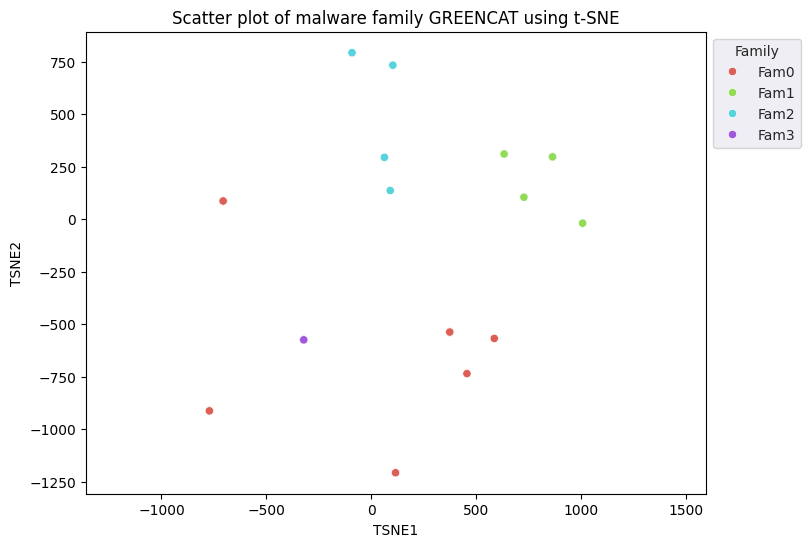

In [29]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Family', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of malware family GREENCAT using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## PROCESO REALIZADO
En resumen de todo el proceso realizado, se cargan los archivos, en este caso, los ejemplares proporcionados. Estos se deben de analizar y clasificar, durante el proceso
se deben desempaquetar, en caso de ser necesario. Se suben o guardan los datos en un .csv. La informacion almacenado incluye funciones importadas de tales. Esto ayuda a poder ver
que tipo de similitudes tienen entre uno y otro y poder determina si pertenece a una u otra familia. Luego de, se realiza un clustering, este ayuda a poder determina a que famlias
pertences como tal. Se visualizan los resultados y las similitudes entre los archivos. AHora bien, algo a tomar en cuenta, es que todo se hace en conjunto, por ello parece algo
engorroso o confuso, pero esto se hizo asi para poder clasificarlos durante el proceso y determinar patrons y comportamientos comunes entre muestras de malware.

SBSCAN
Se debe tomar en cuenta que DBSCAN no utiliza el concepto de inercia como KMeans, ya que se basa en la densidad y no en la optimización de una función objetivo como KMeans. Sin embargo, se calcula el coeficiente de Silhouette para evaluar los resultados de DBSCAN.


# Conclusiones

**Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?**
- Según el gráfico de análisis de Silhouette, el coeficiente más alto se obtiene alrededor de 9 o 10 clusters para K-Means.
- Para DBSCAN, pareciera haber un menor número de clusters efectivos.

**¿En qué medida coincide el coeficiente de Silhouette con el método del codo?**
- En el método del codo, se observa un cambio de pendiente significativo alrededor de 4 a 5 clusters.
- Sin embargo, el coeficiente de Silhouette sigue aumentando hasta 9-10 clusters, lo que sugiere que aunque el método del codo indica un número óptimo menor, la cohesión de      los clusters mejora con más grupos.

**Según los resultados obtenidos de ambos algoritmos, ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?**
- K-Means sugiere alrededor de 9-10 clusters, según el coeficiente de Silhouette.
- DBSCAN parece encontrar menos clusters, posiblemente debido a la presencia de ruido o datos dispersos.
Al final, segun en el conjunto de datos que se genero, se determinaron 9. Algo que da cosa, es el tema del desempaquetado, posiblemente no se realizo bien, pero esa es la conclusion a la que se llega.

**¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a funciones)?**
- Los grafos de similitud muestran agrupaciones basadas en llamadas a funciones API y en strings.
- Se pueden observar familias bien definidas que coinciden en gran medida con los clusters obtenidos por K-Means.
- Sin embargo, puede haber diferencias en DBSCAN debido a su tratamiento de ruido y outliers, lo que puede hacer que algunos ejemplares sean clasificados de manera diferente.

En conclusión, K-Means y DBSCAN muestran agrupaciones similares, aunque DBSCAN puede ser más sensible a la estructura de los datos. El análisis de similitud también refuerza la existencia de múltiples familias, con una fuerte coincidencia entre los métodos. 